In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.io as pio

# Pulling data from database to check that it was stored correctly and also to start analyzing it

In [2]:
conn = psycopg2.connect("host=localhost dbname=rancher port=5430")

In [3]:
def db_table_exists(conn, tablename):
    # thanks to Peter Hansen's answer for this sql
    sql = f"""SELECT * FROM information_schema.tables
            WHERE table_name='{tablename}'"""
    
    # return results of sql query from conn as a pandas dataframe
    results_df = pd.read_sql_query(sql, conn)
    
    # True if we got any results back, False if we didn't
    return bool(len(results_df))

In [4]:
# Instantiate a new cursor object
cur = conn.cursor()

# Use cursor object to create a table in our database for storing census data which will help identify the geographic region a post comes from, if that table doesn't already exist.
cur.execute("""    
    CREATE TABLE IF NOT EXISTS us_census_regions(
    state       text PRIMARY KEY,
    state_code  text,
    us_region   text,
    us_division text
    )
""")

# Copy data from our CSV file into database.  
### We must specify null="" because Python represents null values as an empty string when writing to a CSV file and psycopg2 needs to know how null values are represented in the CSV file in order to properly insert null values into the database
if not db_table_exists(conn, 'us_census_regions'):
    with open('../census-regions/us_census_regions.csv', 'r') as file:
        next(file) # Skip the header row
        cur.copy_from(file, 'us_census_regions', null="", sep=',')
    
# Commit changes to database
conn.commit()

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df_sql = pd.read_sql_query("""   SELECT cl.*
                                      , cr.us_region
                                      , cr.us_division
                                   FROM cl_tutoring AS cl
                              LEFT JOIN us_census_regions as cr
                                     ON cl.state = cr.state
                                  WHERE date_scraped = '2022-02-03'
                                    AND cl.price IS NOT NULL""", con=conn)

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# Segmenting by State

## What is the mean hourly price for tutoring per state?

### Using Python

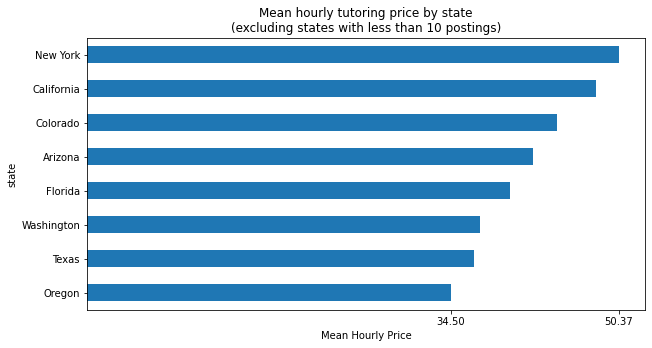

In [6]:
state_counts = df_sql['state'].value_counts().rename('state_counts')

state_counts_df = df_sql.merge(state_counts.to_frame(),
                               left_on='state',
                               right_index=True)

st_cnt_greater_10 = state_counts_df['state_counts']>=10
st_avg_greater_10 = state_counts_df[st_cnt_greater_10].groupby('state')['price'].agg(['mean', 'size'])
st_avg_greater_10.rename(columns={'mean':'mean_price', 'size':'num_postings'}, inplace=True)

fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

st_avg_greater_10['mean_price'].sort_values(ascending=True).plot(kind='barh', ax=ax)
ax.set_xticks([st_avg_greater_10['mean_price'].min(), 
               st_avg_greater_10['mean_price'].max()])
ax.set_xlabel('Mean Hourly Price')
plt.title('Mean hourly tutoring price by state\n(excluding states with less than 10 postings)');

### Using SQL

In [7]:
avg_price_by_state = pd.read_sql_query("""SELECT cl.state
                                               , AVG(cl.price) AS mean_price
                                            FROM cl_tutoring AS cl
                                           WHERE cl.date_scraped = '2022-02-03'
                                             AND cl.price IS NOT NULL
                                        GROUP BY cl.state
                                          HAVING COUNT(cl.id) >= 10
                                        ORDER BY 2 DESC;""", con=conn, index_col='state')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


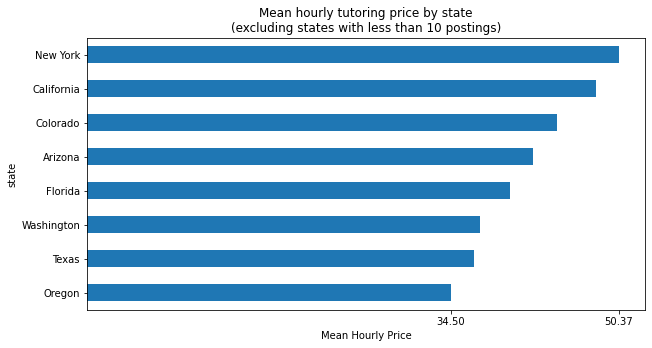

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

avg_price_by_state.sort_values(by='mean_price',ascending=True).plot(kind='barh', ax=ax)
ax.set_xticks([st_avg_greater_10['mean_price'].min(), 
               st_avg_greater_10['mean_price'].max()])
ax.set_xlabel('Mean Hourly Price')
plt.title('Mean hourly tutoring price by state\n(excluding states with less than 10 postings)')
ax.get_legend().remove();

## Which States had the most postings?

### Using Python

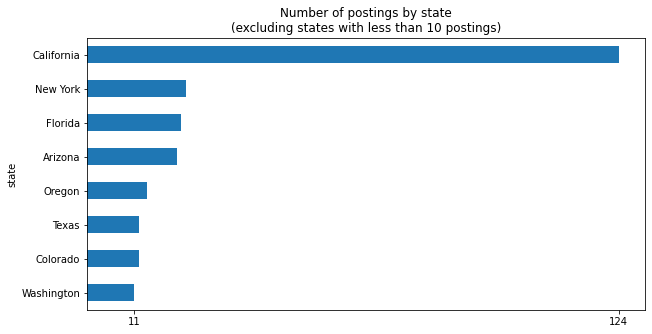

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

st_avg_greater_10['num_postings'].sort_values(ascending=True).plot(kind='barh', ax=ax, )
ax.set_xticks([st_avg_greater_10['num_postings'].min(), st_avg_greater_10['num_postings'].max()])
plt.title('Number of postings by state\n(excluding states with less than 10 postings)');

### Using SQL

In [10]:
post_count_by_state = pd.read_sql_query("""
  SELECT cl.state
       , COUNT(cl.id) AS num_postings
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.state
  HAVING COUNT(cl.id) >= 10
ORDER BY 2 DESC;""", con=conn, index_col='state')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


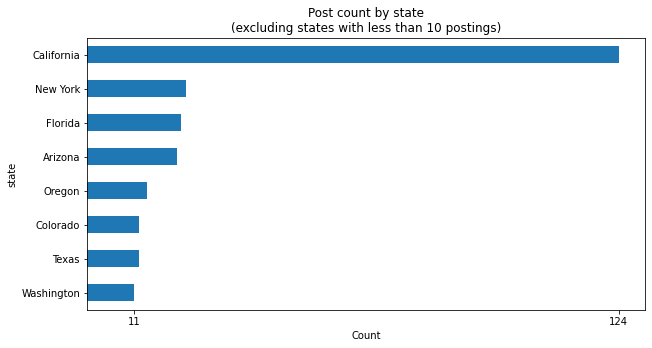

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

post_count_by_state.sort_values(by='num_postings',ascending=True).plot(kind='barh', ax=ax)
ax.set_xticks([post_count_by_state['num_postings'].min(), 
               post_count_by_state['num_postings'].max()])
ax.set_xlabel('Count')
plt.title('Post count by state\n(excluding states with less than 10 postings)')
ax.get_legend().remove();

## Plotly: Mean tutoring price and number of postings by state

### SQL Query

In [254]:
mean_and_count_by_state_sql = pd.read_sql_query("""
WITH mean_price_size_by_state AS (
   SELECT cl.state
        , AVG(cl.price) AS mean_price
        , COUNT(cl.id) AS num_posts
     FROM cl_tutoring AS cl
    WHERE cl.date_scraped = '2022-02-03'
      AND cl.price IS NOT NULL
 GROUP BY cl.state
)

   SELECT cr.state
        , cr.state_code
        , COALESCE(mp.mean_price, 0) AS mean_price 
        , COALESCE(mp.num_posts, 0) AS num_posts 
     FROM us_census_regions AS cr
LEFT JOIN mean_price_size_by_state AS mp
       ON cr.state=mp.state;
""", con=conn)

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [255]:
mean_and_count_by_state_sql.head()

,state,state_code,mean_price,num_posts
0,Alaska,AK,40.000000,1
1,Alabama,AL,25.000000,1
2,Arkansas,AR,0.000000,0
3,Arizona,AZ,42.285714,21
4,California,CA,48.209677,124


### Plotly Code

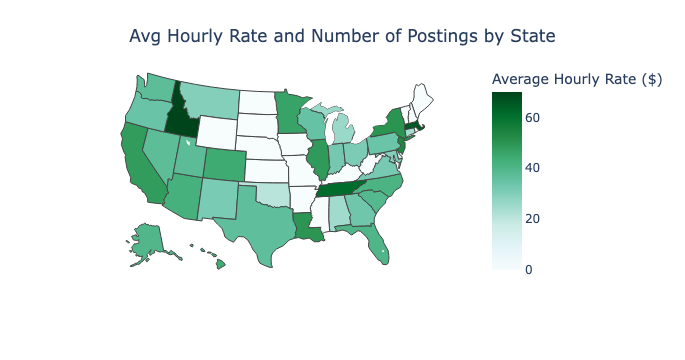

In [303]:
fig = px.choropleth(mean_and_count_by_state_sql,
                    locations='state_code',
                    color='mean_price',
                    color_continuous_scale='BuGn',
                    hover_name='state',
                    hover_data={'mean_price':':.2f', 'num_posts':True, 'state_code':False},
                    locationmode='USA-states',
                    labels={'num_posts':'Number of Posts',
                            'mean_price':'Average Hourly Rate ($)'},
                    scope='usa')

fig.update_layout(
    title={'text':'Avg Hourly Rate and Number of Postings by State',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})

# fig.write_image("/Users/rancher/Google Drive/coding/website/github_pages/images/craigslist_EDA/mean_price_by_state_plotly.png")
fig.show()

pio.write_html(fig, file='/Users/rancher/Google Drive/coding/website/github_pages/mean_price_by_state_plotly.html')

## What is the mean hourly price per state and number of postings for the ENTIRE dataset?

### Using Python

In [20]:
state_list_greater_10 = st_avg_greater_10.index.to_list()

def state_grouper_by_count(df, ind, col):
    state = df[col].loc[ind]
    if df[col].loc[ind] in state_list_greater_10:
        return state 
    else:
        return 'Other'
states_grpby_count = df_sql.groupby(lambda x: state_grouper_by_count(df_sql, x, 'state'))

In [21]:
mean_price_by_state_w_other = states_grpby_count['price'].agg('mean').sort_values(ascending=True)

post_count_by_state_w_other = states_grpby_count['price'].agg('size').sort_values(ascending=True)

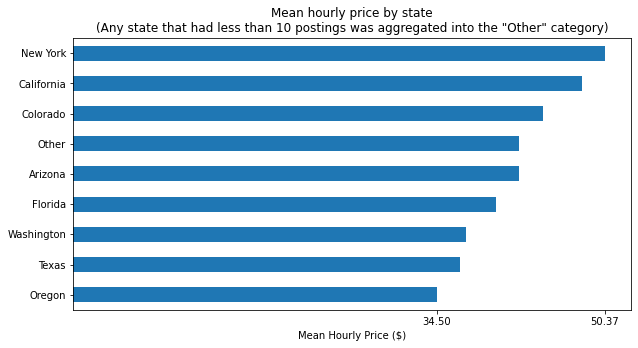

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_price_by_state_w_other.plot(kind='barh', ax=ax)
ax.set_xticks([mean_price_by_state_w_other.min(), 
               mean_price_by_state_w_other.max()])
ax.set_xlabel('Mean Hourly Price ($)')
plt.title('Mean hourly price by state\n(Any state that had less than 10 postings was aggregated into the "Other" category)');

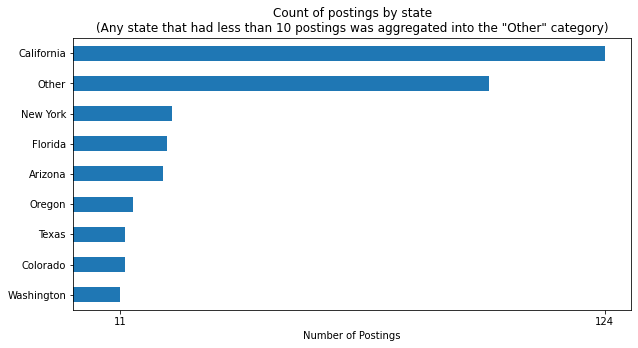

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
post_count_by_state_w_other.plot(kind='barh', ax=ax)
ax.set_xticks([post_count_by_state_w_other.min(), 
               post_count_by_state_w_other.max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by state\n(Any state that had less than 10 postings was aggregated into the "Other" category)');

### Using SQL

In [24]:
average_price_for_all_states = pd.read_sql_query("""
WITH states_greater_10_posts AS (
  SELECT cl.state
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.state
  HAVING COUNT(cl.id) >= 10
)

  SELECT 'Other' AS state
       , AVG(price) AS mean_price
       , COUNT(*) AS num_posts
    FROM cl_tutoring
   WHERE state NOT IN (SELECT state 
                       FROM states_greater_10_posts)
     AND date_scraped = '2022-02-03'
     AND price IS NOT NULL

   UNION 

  SELECT cl.state
       , AVG(cl.price) AS mean_price
       , COUNT(*) AS num_posts
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.state
  HAVING COUNT(cl.price) >= 10
ORDER BY 2 DESC;""", con=conn, index_col='state')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


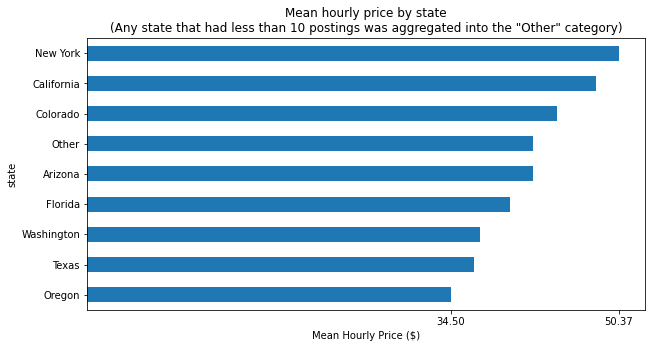

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
average_price_for_all_states['mean_price'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([average_price_for_all_states['mean_price'].min(), 
               average_price_for_all_states['mean_price'].max()])
ax.set_xlabel('Mean Hourly Price ($)')
plt.title('Mean hourly price by state\n(Any state that had less than 10 postings was aggregated into the "Other" category)');

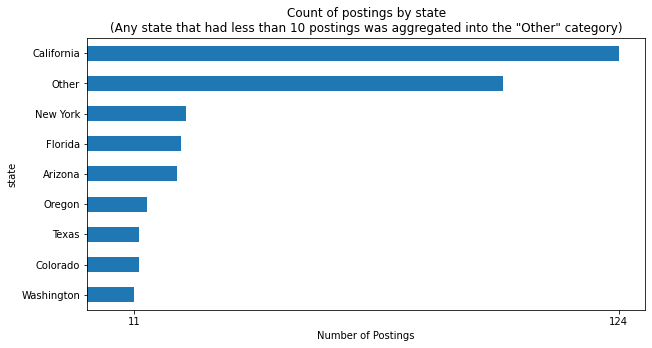

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
average_price_for_all_states['num_posts'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([average_price_for_all_states['num_posts'].min(), 
               average_price_for_all_states['num_posts'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by state\n(Any state that had less than 10 postings was aggregated into the "Other" category)');

# Segmenting by sub-region

## Which state sub-regions had the most postings?

### Using Python

In [12]:
groupby_region = df_sql.groupby('region')
mean_and_size_by_region = groupby_region['price'].agg(['mean', 'size'])

mean_and_size_by_region_greater_10 = mean_and_size_by_region[mean_and_size_by_region['size']>=10]

mean_and_size_by_region_greater_10

,mean,size
region,,
losangeles,54.161765,34
newyork,49.176471,17
orangeco,36.764706,17
phoenix,44.250000,16
sfbayarea,57.100000,40


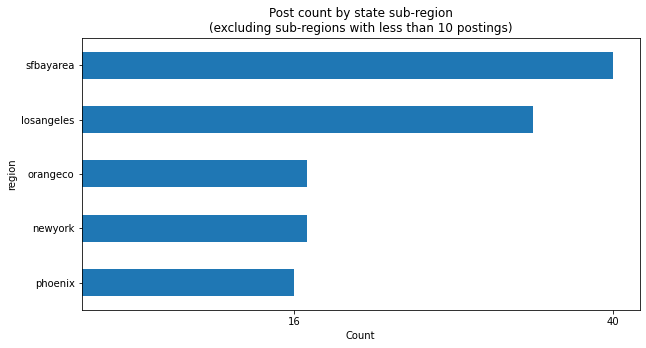

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

mean_and_size_by_region_greater_10['size'].sort_values().plot(kind='barh', ax=ax)

ax.set_xticks([mean_and_size_by_region_greater_10['size'].min(), 
               mean_and_size_by_region_greater_10['size'].max()])
ax.set_xlabel('Count')
plt.title('Post count by state sub-region\n(excluding sub-regions with less than 10 postings)');

### Using SQL

In [14]:
post_count_by_region = pd.read_sql_query("""
  SELECT cl.region
       , COUNT(cl.id) AS num_postings
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.region
  HAVING COUNT(cl.id) >= 10
ORDER BY 2 DESC;""", con=conn, index_col='region')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [15]:
post_count_by_region

,num_postings
region,
sfbayarea,40
losangeles,34
orangeco,17
newyork,17
phoenix,16


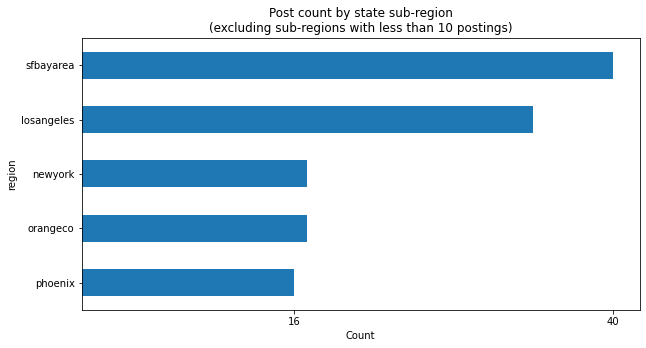

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

post_count_by_region.sort_values(by='num_postings',ascending=True).plot(kind='barh', ax=ax)
ax.set_xticks([post_count_by_region['num_postings'].min(), 
               post_count_by_region['num_postings'].max()])
ax.set_xlabel('Count')
plt.title('Post count by state sub-region\n(excluding sub-regions with less than 10 postings)')
ax.get_legend().remove();

## What is the average hourly price by state sub-region?

### Using Python

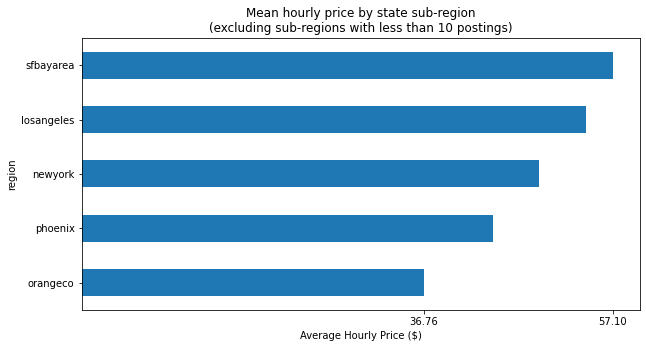

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

mean_and_size_by_region_greater_10['mean'].sort_values().plot(kind='barh', ax=ax)

ax.set_xticks([mean_and_size_by_region_greater_10['mean'].min(), 
               mean_and_size_by_region_greater_10['mean'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price by state sub-region\n(excluding sub-regions with less than 10 postings)');

### Using SQL

In [18]:
mean_price_by_region = pd.read_sql_query("""
  SELECT cl.region
       , AVG(cl.price) AS mean_price
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.region
  HAVING COUNT(cl.id) >= 10
ORDER BY 2 DESC;""", con=conn, index_col='region')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


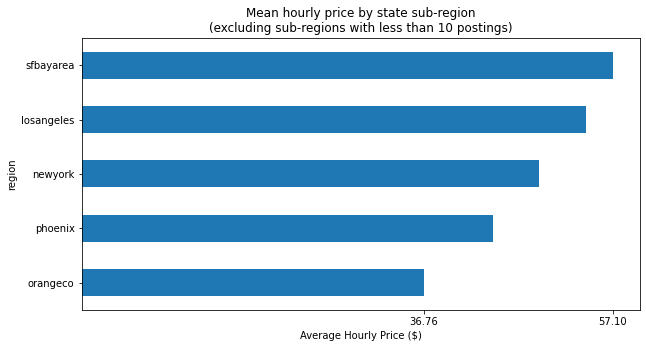

In [19]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

mean_price_by_region['mean_price'].sort_values().plot(kind='barh', ax=ax)

ax.set_xticks([mean_price_by_region['mean_price'].min(), 
               mean_price_by_region['mean_price'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price by state sub-region\n(excluding sub-regions with less than 10 postings)');

# Segmenting by SF Bay Area

## Using Python

## Using SQL

In [270]:
mean_price_and_size_sfbayarea = pd.read_sql_query("""
SELECT subregion
     , AVG(price) AS mean_price
     , COUNT(id) AS num_posts
FROM cl_tutoring
WHERE date_scraped = '2022-02-03'
  AND price IS NOT NULL
  AND region = 'sfbayarea'
GROUP BY subregion
ORDER BY 3 DESC;
""", con=conn, index_col='subregion')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [271]:
mean_price_and_size_sfbayarea

,mean_price,num_posts
subregion,,
San Francisco,79.807692,13
East Bay,48.863636,11
South Bay,40.928571,7
Peninsula,48.125000,4
Santa Cruz,46.666667,3
North Bay,45.000000,2


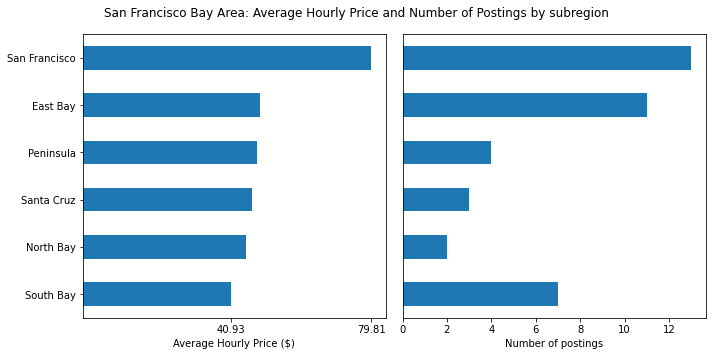

In [292]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

mean_price_and_size_sfbayarea['mean_price'].sort_values().plot(kind='barh', ax=ax[0])
ax[0].set_xlabel('Average Hourly Price ($)')
ax[0].set_ylabel('')
ax[0].set_xticks([mean_price_and_size_sfbayarea['mean_price'].min(), mean_price_and_size_sfbayarea['mean_price'].max()])


mean_price_and_size_sfbayarea.sort_values(by='mean_price')['num_posts'].plot(kind='barh', ax=ax[1])
ax[1].get_yaxis().set_visible(False)
ax[1].set_xlabel('Number of postings')

fig.suptitle('San Francisco Bay Area: Average Hourly Price and Number of Postings by subregion')
plt.tight_layout()

plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/craigslist_EDA/mean_price_and_num_posts_sfbayarea.png", bbox_inches="tight");

# Segmenting by US Census Region

## What is the mean hourly price by US Census Region?

### Using Python

In [28]:
groupby_us_region = df_sql.groupby('us_region')
mean_and_size_by_us_region = groupby_us_region['price'].agg(['mean', 'size'])

mean_and_size_by_us_region

,mean,size
us_region,,
Midwest,38.181159,23
Northeast,48.981481,45
South,40.931818,66
West,45.013201,202


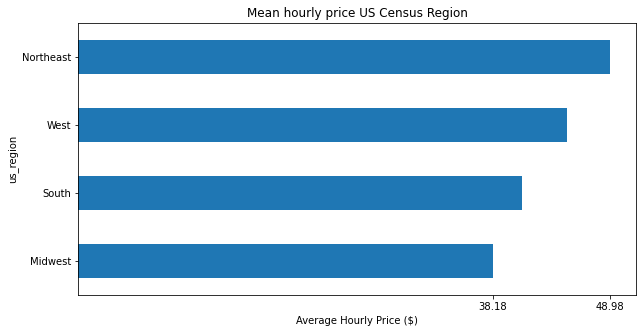

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_size_by_us_region['mean'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_size_by_us_region['mean'].min(), 
               mean_and_size_by_us_region['mean'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price US Census Region');

### Using SQL

In [33]:
mean_and_count_by_us_census_region = pd.read_sql_query("""
WITH cl_tutoring_w_census AS (
   SELECT cl.*, cr.us_region, cr.us_division
     FROM cl_tutoring AS cl
LEFT JOIN us_census_regions AS cr
       ON cl.state = cr.state
    WHERE cl.date_scraped = '2022-02-03'
      AND cl.price IS NOT NULL
  )

   SELECT cltwc.us_region
        , AVG(cltwc.price) AS mean_price
        , COUNT(cltwc.id) AS num_postings
     FROM cl_tutoring_w_census AS cltwc
 GROUP BY cltwc.us_region;
""", con=conn, index_col='us_region')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


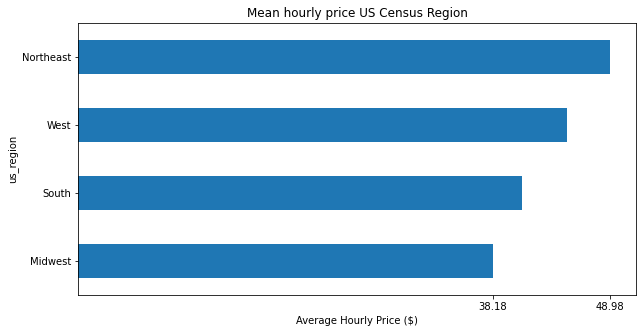

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_region['mean_price'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_region['mean_price'].min(), 
               mean_and_count_by_us_census_region['mean_price'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price US Census Region');

## What US Census Region had the most postings?

### Using Python

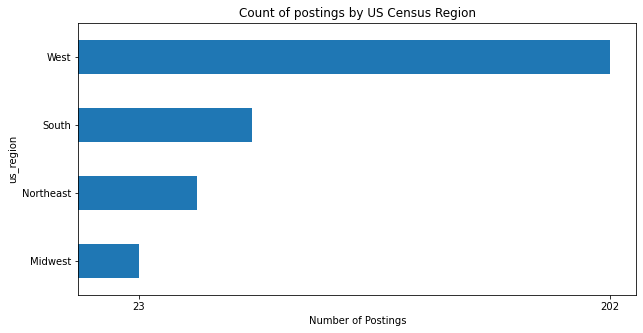

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_size_by_us_region['size'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_size_by_us_region['size'].min(), 
               mean_and_size_by_us_region['size'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by US Census Region');

### Using SQL

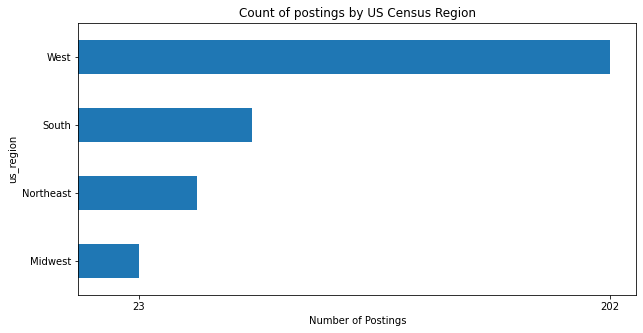

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_region['num_postings'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_region['num_postings'].min(), 
               mean_and_count_by_us_census_region['num_postings'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by US Census Region');

## Plotly: Mean tutoring price and number of postings by US Census Region

### SQL Query

In [245]:
mean_and_count_by_us_census_region_sql = pd.read_sql_query("""
WITH cl_tutoring_2022_02_03 AS (
    SELECT *
    FROM cl_tutoring
    WHERE date_scraped = '2022-02-03'
      AND price IS NOT NULL
      ),

cl_tutoring_w_census AS (
   SELECT cr.state
        , cr.state_code
        , cr.us_region 
        , COALESCE(cl.price, 0) AS price
        , cl.id
     FROM us_census_regions AS cr
LEFT JOIN cl_tutoring_2022_02_03 AS cl
       ON cr.state = cl.state
  ),

mean_price_size_by_us_region as (SELECT state
     , state_code
     , us_region
     , AVG(price) OVER (PARTITION BY us_region) AS mean_price
     , COUNT(id) OVER (PARTITION BY us_region) AS num_posts
     , ROW_NUMBER() OVER (PARTITION BY us_region, state) AS rn
 FROM cl_tutoring_w_census)

SELECT *
FROM mean_price_size_by_us_region
WHERE rn = 1
ORDER BY 1;
""", con=conn)

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [246]:
mean_and_count_by_us_census_region_sql.head()

,state,state_code,us_region,mean_price,num_posts,rn
0,Alabama,AL,South,38.592857,66,1
1,Alaska,AK,West,44.791461,202,1
2,Arizona,AZ,West,44.791461,202,1
3,Arkansas,AR,South,38.592857,66,1
4,California,CA,West,44.791461,202,1


### Plotly Code

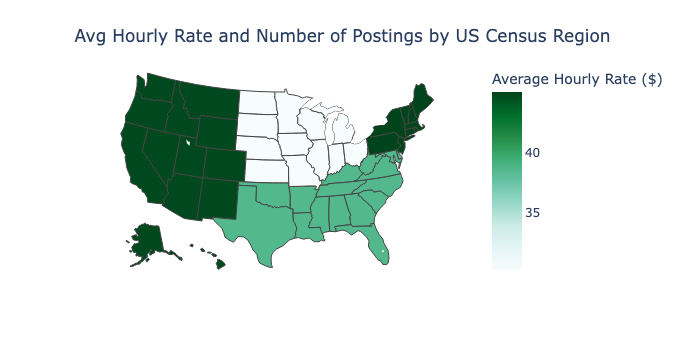

In [269]:
fig = px.choropleth(mean_and_count_by_us_census_region_sql,
                    locations='state_code',
                    color='mean_price',
                    color_continuous_scale='BuGn',
                    hover_name='us_region',
                    hover_data={'mean_price':':.2f', 'num_posts':True, 'state':False, 'state_code':False},
                    locationmode='USA-states',
                    labels={'num_posts':'Number of Posts',
                            'mean_price':'Average Hourly Rate ($)'},
                    scope='usa')

fig.update_layout(
    title={'text':'Avg Hourly Rate and Number of Postings by US Census Region',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})


fig.show()

pio.write_html(fig, file='/Users/rancher/Google Drive/coding/website/github_pages/mean_price_by_us_census_region_plotly.html')

# Segmenting by US Census Division

## What is the mean hourly price by US Census Division?

### Using Python

In [36]:
groupby_us_division = df_sql.groupby('us_division')
mean_and_count_by_us_census_division = groupby_us_division['price'].agg(['mean', 'size'])

mean_and_count_by_us_census_division

,mean,size
us_division,,
East North Central,34.510417,16
East South Central,49.166667,3
Middle Atlantic,49.402778,36
Mountain,41.819728,49
New England,47.296296,9
Pacific,46.035948,153
South Atlantic,42.585106,47
West North Central,46.571429,7
West South Central,34.531250,16


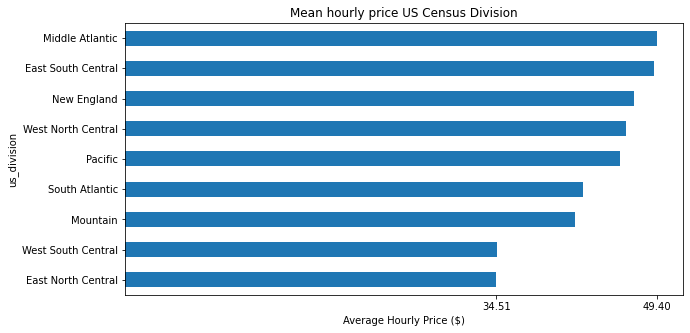

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_division['mean'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_division['mean'].min(), 
               mean_and_count_by_us_census_division['mean'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price US Census Division');

### Using SQL

In [40]:
mean_and_count_by_us_census_division = pd.read_sql_query("""
WITH cl_tutoring_w_census AS (
   SELECT cl.*, cr.us_region, cr.us_division
     FROM cl_tutoring AS cl
LEFT JOIN us_census_regions AS cr
       ON cl.state = cr.state
    WHERE cl.date_scraped = '2022-02-03'
      AND cl.price IS NOT NULL
  )

   SELECT cltwc.us_division
        , AVG(cltwc.price) AS mean_price
        , COUNT(cltwc.id) AS num_postings
     FROM cl_tutoring_w_census AS cltwc
 GROUP BY cltwc.us_division;
""", con=conn, index_col='us_division')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


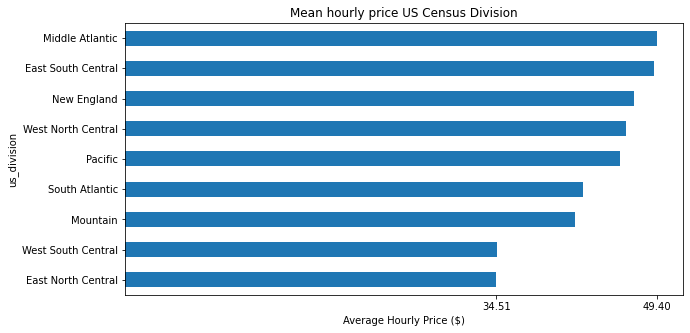

In [41]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_division['mean_price'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_division['mean_price'].min(), 
               mean_and_count_by_us_census_division['mean_price'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price US Census Division');

## What US Census Division had the most postings?

### Using Python

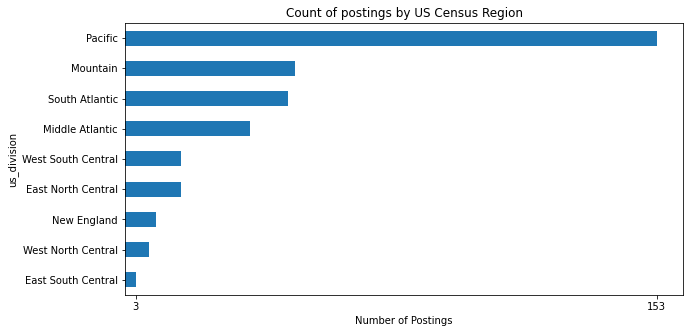

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_division['size'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_division['size'].min(), 
               mean_and_count_by_us_census_division['size'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by US Census Region');

### Using SQL

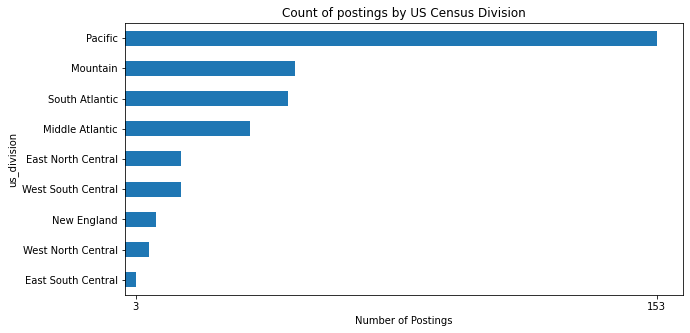

In [42]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_division['num_postings'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_division['num_postings'].min(), 
               mean_and_count_by_us_census_division['num_postings'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by US Census Division');

# Using GeoPandas

In [117]:
states = gpd.read_file('~/Google Drive/Coding/PycharmProjects/police_killings/geopandas/data/usa-states-census-2014.shp')

# For some reason states like New Jersey, New Hampshire, Connecticut, Maine, Vermont, Pennsylvania, Massachusets, Rhode Island and New York are duplicated in the census data, so I'm dropping them from the table.
#states.drop_duplicates(inplace=True)

states = states.to_crs("EPSG:3395")

states.shape

(58, 11)

In [118]:
groupby_state = df_sql.groupby('state')
mean_price_and_size_by_state = groupby_state['price'].agg(['mean', 'size'])

mean_price_and_size_by_state_w_coords = pd.merge(left=states, right=mean_price_and_size_by_state, left_on='NAME', right_index=True, how='left')

mean_price_and_size_by_state_w_coords['coords'] = mean_price_and_size_by_state_w_coords['geometry'].apply(lambda x: x.representative_point().coords[:])

mean_price_and_size_by_state_w_coords['coords'] = [coords[0] for coords in mean_price_and_size_by_state_w_coords['coords']]





# mean_price_and_size_by_state_w_coords[mean_price_and_size_by_state_w_coords['size']>=10]

In [130]:
mean_price_and_size_by_state_w_coords.sort_values(by='size', ascending=False).head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry,mean,size,coords
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,MULTIPOLYGON Z (((-13201820.240 3933920.113 0....,48.209677,124.0,"(-13368263.380805373, 4469804.965681642)"
13,36,01779796,0400000US36,36,NY,New York,00,122054577774,19242052501,Northeast,MULTIPOLYGON Z (((-8017110.170 5024664.442 0.0...,50.369565,23.0,"(-8468185.84474219, 5252060.881423211)"
49,36,01779796,0400000US36,36,NY,New York,00,122054577774,19242052501,Northeast,MULTIPOLYGON Z (((-8017110.170 5024664.442 0.0...,50.369565,23.0,"(-8468185.84474219, 5252060.881423211)"
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,MULTIPOLYGON Z (((-9107236.006 2805107.013 0.0...,40.090909,22.0,"(-9089877.243804589, 3216237.862855795)"
19,04,01779777,0400000US04,04,AZ,Arizona,00,294205282243,1027790845,Southwest,"POLYGON Z ((-12779442.255 3818472.179 0.000, -...",42.285714,21.0,"(-12426048.244437095, 4033474.746184238)"


In [139]:
mean_price_and_size_by_state_w_coords.dtypes

STATEFP       object
STATENS       object
AFFGEOID      object
GEOID         object
STUSPS        object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
region        object
geometry    geometry
mean         float64
size         float64
coords        object
dtype: object

In [143]:
type(mean_price_and_size_by_state_w_coords['size'][0])

numpy.float64

In [158]:
test = mean_price_and_size_by_state_w_coords.copy()

In [159]:
test = test[['NAME', 'size', 'STUSPS', 'mean']]
test.rename(columns={'NAME':'State', 'STUSPS':'Code'}, inplace=True)

In [160]:
test['size'].fillna(0, inplace=True)

In [161]:
test.head()

,State,size,Code,mean
0,California,124.0,CA,48.209677
1,District of Columbia,8.0,DC,64.375000
2,Florida,22.0,FL,40.090909
3,Georgia,5.0,GA,33.500000
4,Idaho,2.0,ID,70.000000


In [214]:
test.shape

(58, 4)

In [238]:
mean_and_count_by_us_census_division_sql

,state,state_code,mean_price,num_posts
0,Alaska,AK,40.000000,1
1,Alabama,AL,25.000000,1
2,Arkansas,AR,0.000000,0
3,Arizona,AZ,42.285714,21
4,California,CA,48.209677,124
5,Colorado,CO,44.541667,12
6,Connecticut,CT,24.625000,4
7,District of Columbia,DC,64.375000,8
8,Delaware,DE,17.500000,1
9,Florida,FL,40.090909,22


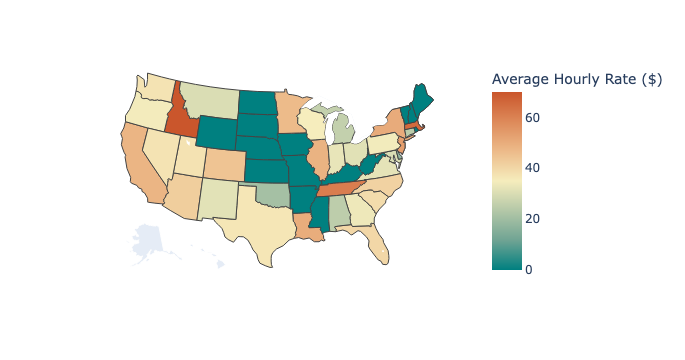

In [236]:
fig = px.choropleth(test,
                    locations='Code',
                    color='mean',
                    color_continuous_scale='geyser',
                    hover_name='State',
                    hover_data={'mean':':.2f', 'size':True, 'Code':False},
                    locationmode='USA-states',
                    labels={'size':'Number of Posts',
                            'mean':'Average Hourly Rate ($)'},
                    scope='usa')

fig.show()
import plotly.io as pio
pio.write_html(fig, file='/Users/rancher/Google Drive/coding/website/github_pages/mean_price_by_state_plotly.html');

### Using SQL for Plotly

In [254]:
mean_and_count_by_state_sql = pd.read_sql_query("""
WITH mean_price_size_by_state AS (
   SELECT cl.state
        , AVG(cl.price) AS mean_price
        , COUNT(cl.id) AS num_posts
     FROM cl_tutoring AS cl
    WHERE cl.date_scraped = '2022-02-03'
      AND cl.price IS NOT NULL
 GROUP BY cl.state
)

   SELECT cr.state
        , cr.state_code
        , COALESCE(mp.mean_price, 0) AS mean_price 
        , COALESCE(mp.num_posts, 0) AS num_posts 
     FROM us_census_regions AS cr
LEFT JOIN mean_price_size_by_state AS mp
       ON cr.state=mp.state;
""", con=conn)

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [255]:
mean_and_count_by_state_sql.head()

,state,state_code,mean_price,num_posts
0,Alaska,AK,40.000000,1
1,Alabama,AL,25.000000,1
2,Arkansas,AR,0.000000,0
3,Arizona,AZ,42.285714,21
4,California,CA,48.209677,124


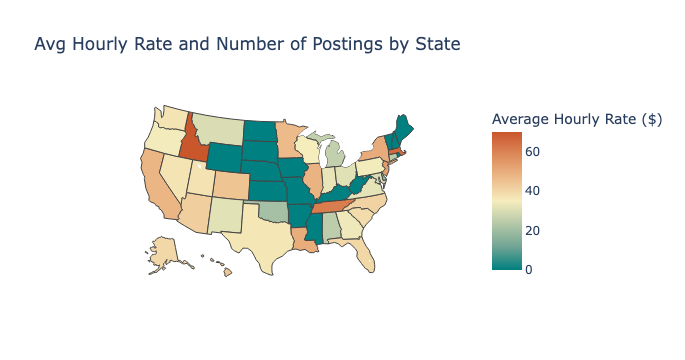

In [256]:
fig = px.choropleth(mean_and_count_by_state_sql,
                    locations='state_code',
                    color='mean_price',
                    color_continuous_scale='geyser',
                    hover_name='state',
                    hover_data={'mean_price':':.2f', 'num_posts':True, 'state_code':False},
                    locationmode='USA-states',
                    labels={'num_posts':'Number of Posts',
                            'mean_price':'Average Hourly Rate ($)'},
                    scope='usa',
                    title='Avg Hourly Rate and Number of Postings by State')

fig.show()


pio.write_html(fig, file='/Users/rancher/Google Drive/coding/website/github_pages/mean_price_by_state_plotly.html')

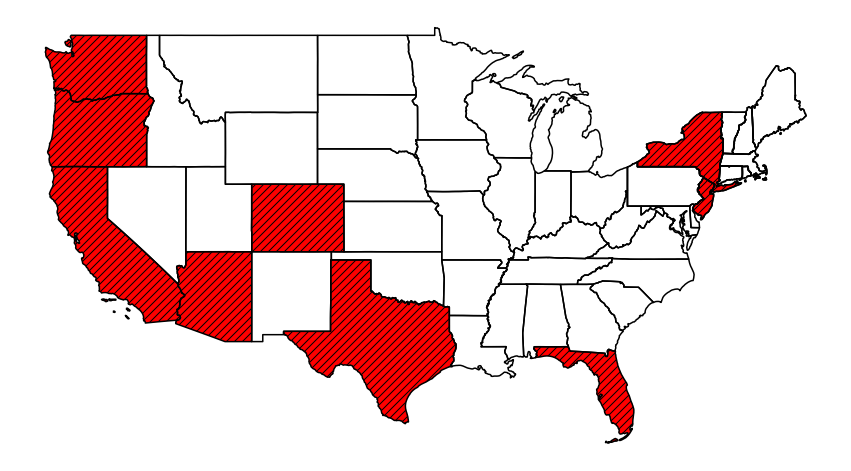

In [109]:
us_boundary_map = mean_price_and_size_by_state_w_coords.boundary.plot(figsize=(15,10), color='black')

mean_price_and_size_by_state_w_coords.sort_values(by='size', ascending=False)[0:10].plot(ax=us_boundary_map, color='red', hatch="///")
plt.axis('off');

# Scratch work

In [ ]:
df_sql['region'].value_counts()

In [ ]:
df_sql['subregion'].value_counts()

In [ ]:
df_sql['price'].mean()

In [ ]:
df_sql['price'].median()

In [ ]:
df_sql.groupby(by='region')['price'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

In [ ]:
df_sql[(df_sql['region']=='los_angeles') & (df_sql['price'] > 60)]['price']

In [ ]:
df_sql[df_sql['region']=='los_angeles'].boxplot(column='price')
plt.scatter(df_sql[df_sql['region']=='los_angeles']['price'])

In [ ]:
sns.boxplot(x='region', y='price', data=df_sql[df_sql['region']=='los_angeles'])
sns.swarmplot(x='region', y='price', data=df_sql[df_sql['region']=='los_angeles'], color='r');